<a href="https://colab.research.google.com/github/arijeetchoudhury100/digit_recognition_2hiddenDNN/blob/master/mnist_DNN_2hidden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline

Using TensorFlow backend.


In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [784, 1])
    
    z3 = forward_propagation(x, params)
    p = tf.argmax(z3)
    
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [0]:
def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)].T
  return Y

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
#flatten images
x_train_flattened = x_train.reshape(x_train.shape[0],-1).T
x_test_flattened = x_test.reshape(x_test.shape[0],-1).T
#normalize images
x_train = x_train_flattened/255
x_test = x_test_flattened/255
y_train = y_train.reshape(1,len(y_train))
y_test = y_test.reshape(1,len(y_test))
#convert to one hot encoding
y_train = convert_to_one_hot(y_train,10)
y_test = convert_to_one_hot(y_test,10)

In [8]:
print(y_train.shape)
print(y_test.shape)

(10, 60000)
(10, 10000)


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


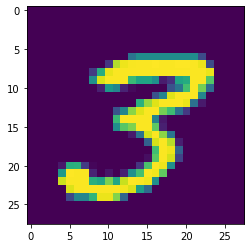

In [9]:
plt.imshow(x_train[:,203].reshape(28,28))
print(y_train[:,203])

In [0]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(dtype = tf.float32,shape = [n_x,None])
    Y = tf.placeholder(dtype = tf.float32,shape = [n_y,None])
    return X, Y

In [0]:
def initialize_parameters():
    tf.set_random_seed(1)                   
    W1 = tf.get_variable("W1",[25,784],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1",[25,1],initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2",[12,25],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2",[12,1],initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3",[10,12],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3",[10,1],initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(W1,X),b1)                                           
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                              
    return Z3

In [0]:
def compute_cost(Z3, Y):
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = labels))
    return cost

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x,n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X,parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3,Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict = {X : minibatch_X, Y : minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 79.625912
Cost after epoch 100: 4.079067
Cost after epoch 200: 1.967907
Cost after epoch 300: 0.816047
Cost after epoch 400: 0.246710
Cost after epoch 500: 0.050913
Cost after epoch 600: 0.018115
Cost after epoch 700: 0.005289
Cost after epoch 800: 0.003517
Cost after epoch 900: 0.022744
Cost after epoch 1000: 0.000422
Cost after epoch 1100: 0.000677
Cost after epoch 1200: 0.000199
Cost after epoch 1300: 0.000125
Cost aft

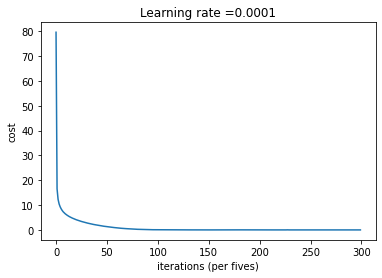

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.9554


In [15]:
parameters = model(x_train,y_train,x_test,y_test)

In [0]:
import cv2

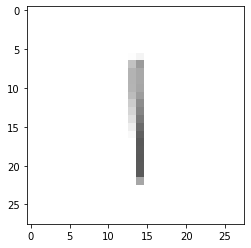

In [49]:
img = cv2.imread('1.jpg')
resized = cv2.resize(img, (28,28), interpolation = cv2.INTER_AREA) 
plt.imshow(resized)

In [0]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
gray = gray.flatten()
gray = gray.reshape(784,1)
gray = gray/255

In [51]:
print(gray.shape)

(784, 1)


In [55]:
my_image_prediction = predict(x_test[:,100].reshape(784,1), parameters)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

Your algorithm predicts: y = 6


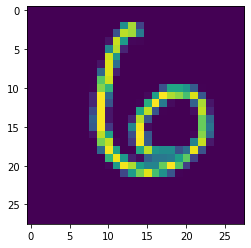

In [54]:
plt.imshow(x_test[:,100].reshape(28,28))